# Assignment 4 — CRISP-DM Case Study (House Prices)

Dataset: [`michaelmallari/house-prices-advanced-regression-techniques`](https://huggingface.co/datasets/michaelmallari/house-prices-advanced-regression-techniques)

Goals:
- Practice end-to-end CRISP-DM on a tabular regression task (predict `SalePrice`).
- Compare baselines vs. tree-based models; report RMSE/MAE/R².
- Save figures for documentation and support a short video walkthrough.

Environment: Python 3.11 (`.venv`), scikit-learn, pandas, seaborn, datasets.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
RNG = 42

pd.set_option("display.max_columns", 20)
sns.set_theme(style="whitegrid")

In [2]:
# Load dataset from Hugging Face
ds_train = load_dataset("michaelmallari/house-prices-advanced-regression-techniques", split="train")
df = ds_train.to_pandas()
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
# Basic data checks
target = "SalePrice"
X = df.drop(columns=[target])
y = df[target]

missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts.head(10)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64

PosixPath('figures/target_distribution.png')

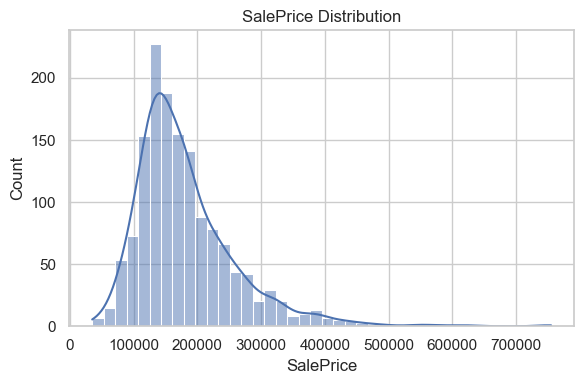

In [4]:
# Target distribution
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True, bins=40)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.tight_layout()
target_fig = FIG_DIR / "target_distribution.png"
plt.savefig(target_fig)
target_fig

PosixPath('figures/correlation_top_numeric.png')

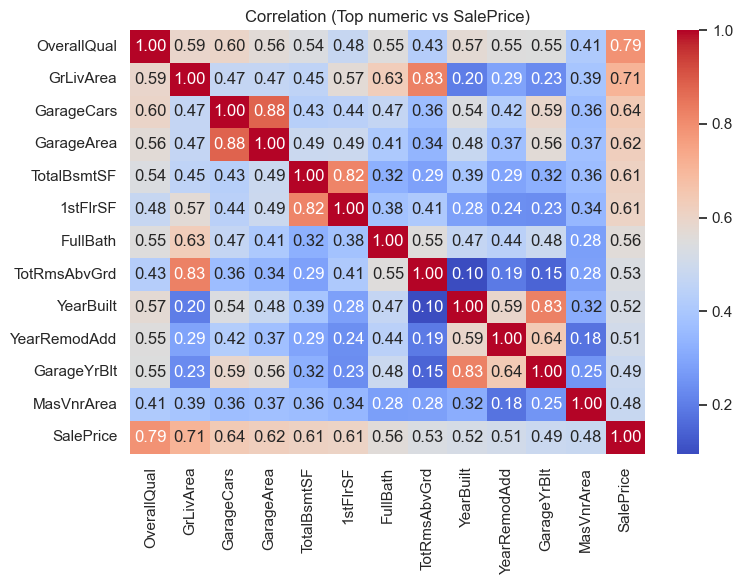

In [5]:
# Correlation heatmap for top numeric features w.r.t target
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
corr = df[numeric_cols.tolist() + [target]].corr()[target].drop(target)
top_corr = corr.abs().sort_values(ascending=False).head(12).index
plt.figure(figsize=(8,6))
sns.heatmap(df[list(top_corr) + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation (Top numeric vs SalePrice)")
plt.tight_layout()
corr_fig = FIG_DIR / "correlation_top_numeric.png"
plt.savefig(corr_fig)
corr_fig

In [6]:
# Preprocessing: split, then ColumnTransformer with imputers and one-hot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [7]:
def evaluate_model(model, name: str):
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {
        "name": name,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "pipeline": pipe,
    }

results = []

results.append(evaluate_model(DummyRegressor(strategy="median"), "Dummy (median)"))
results.append(evaluate_model(RandomForestRegressor(n_estimators=200, random_state=RNG, n_jobs=-1), "RandomForest"))
results.append(evaluate_model(GradientBoostingRegressor(random_state=RNG), "GradientBoosting"))

pd.DataFrame([{k: v for k, v in r.items() if k != "pipeline"} for r in results])

,name,rmse,mae,r2
0,Dummy (median),88667.167506,59568.250000,-0.024972
1,RandomForest,29103.950039,17576.792911,0.889569
2,GradientBoosting,27827.582647,17319.468353,0.899043


In [8]:
# Pick best model by RMSE
best = sorted(results, key=lambda d: d["rmse"])[0]
best_name = best["name"]
best_pipe = best["pipeline"]
best_metrics = {k: v for k, v in best.items() if k in ["rmse", "mae", "r2"]}
best_name, best_metrics

('GradientBoosting',
 {'rmse': 27827.582646520637,
  'mae': 17319.468352569376,
  'r2': 0.8990428392441322})

PosixPath('figures/permutation_importance.png')

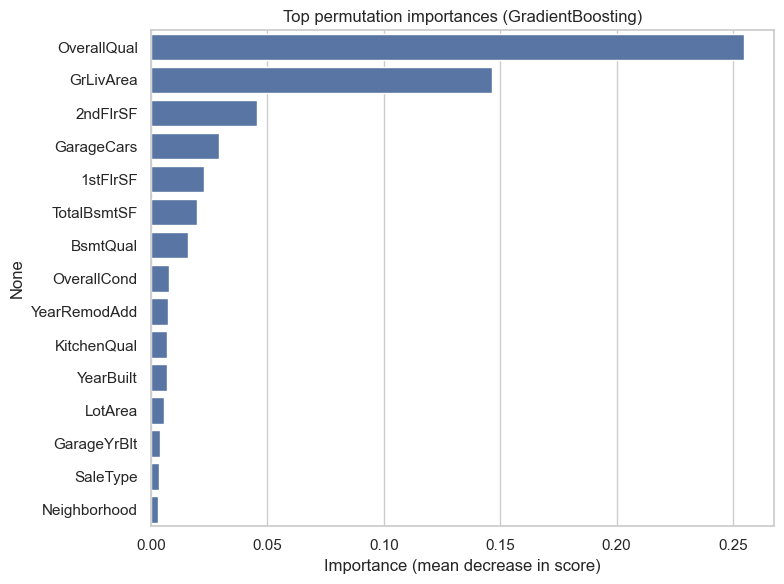

In [9]:
# Permutation importance on raw feature set (uses original column names)
X_sample = X_test.sample(n=min(200, len(X_test)), random_state=RNG)
y_sample = y_test.loc[X_sample.index]
perm = permutation_importance(best_pipe, X_sample, y_sample, n_repeats=8, random_state=RNG)
importances = pd.Series(perm.importances_mean, index=X_sample.columns)
top_imp = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title(f"Top permutation importances ({best_name})")
plt.xlabel("Importance (mean decrease in score)")
plt.tight_layout()
imp_fig = FIG_DIR / "permutation_importance.png"
plt.savefig(imp_fig)
imp_fig

## Next steps / deployment considerations
- Calibrate hyperparameters (e.g., tune RF depth/leaves, GB learning rate) via cross-validation.
- Log model + preprocessing using `joblib` or `skops`, version datasets, and emit a prediction service (FastAPI) if deploying.
- Add bias/fairness checks for neighborhood-related features; consider SHAP for local explanations.

## Extended analysis: log target, tuning, residuals, segments, SHAP

In [10]:

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import shap

# Log-transform target experiment on the best model type
log_model = GradientBoostingRegressor(random_state=RNG)
log_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("tt", TransformedTargetRegressor(
        regressor=log_model,
        func=lambda y: np.log1p(y),
        inverse_func=lambda y: np.expm1(y)
    ))
])
log_pipe.fit(X_train, y_train)
log_preds = log_pipe.predict(X_test)
log_rmse = mean_squared_error(y_test, log_preds, squared=False)
log_mae = mean_absolute_error(y_test, log_preds)
log_r2 = r2_score(y_test, log_preds)
{"rmse": log_rmse, "mae": log_mae, "r2": log_r2}


{'rmse': 27626.370047988996,
 'mae': 16654.35463028446,
 'r2': 0.9004975405983011}

In [11]:

# Re-select best model including log-target variant
candidates = results + [{
    "name": "GradientBoosting (log target)",
    "rmse": log_rmse,
    "mae": log_mae,
    "r2": log_r2,
    "pipeline": log_pipe,
}]
best = sorted(candidates, key=lambda d: d["rmse"])[0]
best_name = best["name"]
best_pipe = best["pipeline"]
best_metrics = {k: v for k, v in best.items() if k in ["rmse", "mae", "r2"]}
best_name, best_metrics


('GradientBoosting (log target)',
 {'rmse': 27626.370047988996,
  'mae': 16654.35463028446,
  'r2': 0.9004975405983011})

In [12]:

# Quick hyperparameter search for GradientBoosting (log-target) with 5 iterations
param_dist = {
    "tt__regressor__n_estimators": [200, 300, 400],
    "tt__regressor__learning_rate": [0.05, 0.075, 0.1],
    "tt__regressor__max_depth": [2, 3, 4],
}
base = Pipeline(steps=[
    ("prep", preprocessor),
    ("tt", TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(random_state=RNG),
        func=lambda y: np.log1p(y),
        inverse_func=lambda y: np.expm1(y)
    )),
])
search = RandomizedSearchCV(
    base,
    param_distributions=param_dist,
    n_iter=5,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=RNG,
    n_jobs=-1,
)
search.fit(X, y)
tuned_rmse = -search.best_score_
{"cv_rmse": tuned_rmse, "best_params": search.best_params_}


{'cv_rmse': 27480.592430408182,
 'best_params': {'tt__regressor__n_estimators': 300,
  'tt__regressor__max_depth': 3,
  'tt__regressor__learning_rate': 0.075}}

PosixPath('figures/residuals_vs_pred.png')

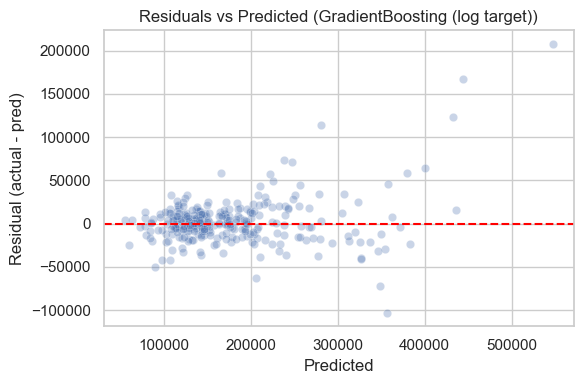

In [13]:

# Residual diagnostics using the selected best model
preds = best_pipe.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
sns.scatterplot(x=preds, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual (actual - pred)')
plt.title(f'Residuals vs Predicted ({best_name})')
plt.tight_layout()
resid_fig = FIG_DIR / 'residuals_vs_pred.png'
plt.savefig(resid_fig)
resid_fig


PosixPath('figures/residual_hist.png')

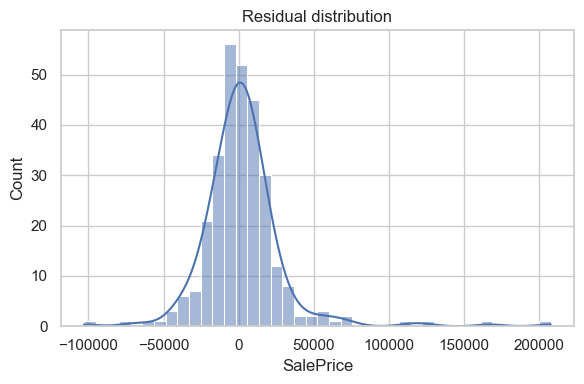

In [14]:

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title('Residual distribution')
plt.tight_layout()
resid_hist_fig = FIG_DIR / 'residual_hist.png'
plt.savefig(resid_hist_fig)
resid_hist_fig


In [15]:

# Segment performance by Neighborhood (top 10 by count)
seg = (
    pd.DataFrame({"Neighborhood": X_test["Neighborhood"], "y": y_test, "pred": preds})
    .assign(abs_err=lambda d: (d["y"] - d["pred"]).abs())
)
seg_summary = (
    seg.groupby("Neighborhood")
      .agg(count=("y", "size"), mae=("abs_err", "mean"))
      .sort_values("count", ascending=False)
      .head(10)
)
seg_summary


,count,mae
Neighborhood,,
NAmes,44,9044.963006
CollgCr,35,11343.998240
OldTown,22,10638.549669
Somerst,17,15235.630595
Sawyer,16,9786.837523
NridgHt,16,46213.794396
SawyerW,15,18275.841255
Gilbert,14,10368.935935
Edwards,13,16662.563720


In [16]:

# 3-fold CV on the selected best pipeline
cv_scores = cross_val_score(best_pipe, X, y, cv=3, scoring='neg_root_mean_squared_error')
{"cv_rmse_mean": (-cv_scores).mean(), "cv_rmse_std": (-cv_scores).std()}


{'cv_rmse_mean': 27650.178484545027, 'cv_rmse_std': 3106.092671114893}

PosixPath('figures/shap_beeswarm.png')

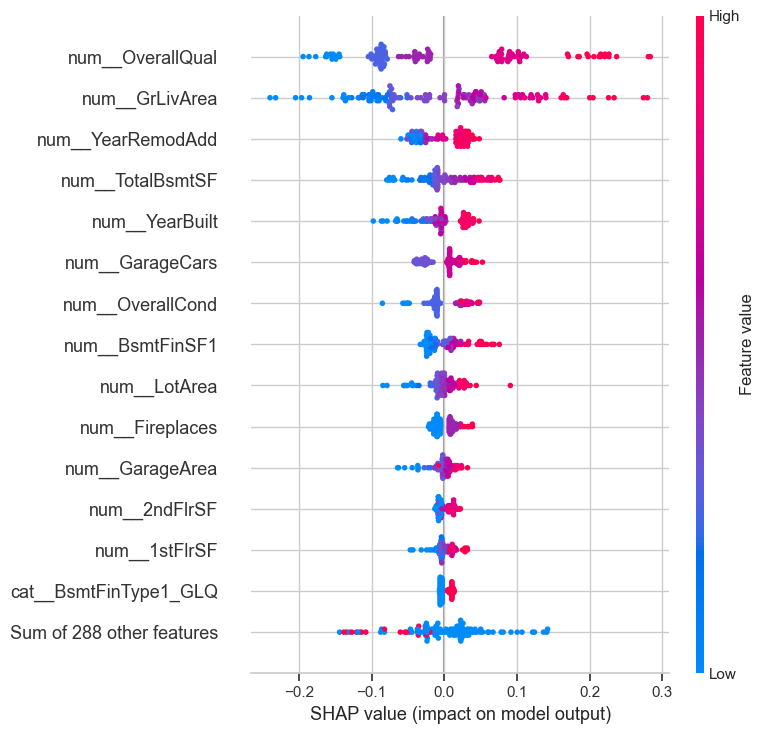

In [17]:

# SHAP summary (sampled for speed)
feature_names = best_pipe.named_steps["prep"].get_feature_names_out()
X_shap = X_test.sample(n=min(120, len(X_test)), random_state=RNG)
X_proc = best_pipe.named_steps["prep"].transform(X_shap)
if hasattr(X_proc, "toarray"):
    X_proc = X_proc.toarray()

# Extract underlying regressor (handles log-target wrapper)
reg = None
if "tt" in best_pipe.named_steps:
    reg = best_pipe.named_steps["tt"].regressor_
elif "model" in best_pipe.named_steps:
    reg = best_pipe.named_steps["model"]

explainer = shap.Explainer(reg, X_proc, feature_names=feature_names)
shap_values = explainer(X_proc)
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.tight_layout()
shap_fig = FIG_DIR / "shap_beeswarm.png"
plt.savefig(shap_fig, bbox_inches="tight")
shap_fig


In [18]:

# Broader hyperparameter search for log-target GradientBoosting (more iterations)
param_dist = {
    "tt__regressor__n_estimators": [200, 300, 400, 500],
    "tt__regressor__learning_rate": [0.05, 0.075, 0.1, 0.125],
    "tt__regressor__max_depth": [2, 3, 4],
}
base = Pipeline(steps=[
    ("prep", preprocessor),
    ("tt", TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(random_state=RNG),
        func=lambda y: np.log1p(y),
        inverse_func=lambda y: np.expm1(y)
    )),
])
search = RandomizedSearchCV(
    base,
    param_distributions=param_dist,
    n_iter=12,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=RNG,
    n_jobs=-1,
)
search.fit(X, y)
best_tuned_rmse = -search.best_score_
best_tuned_params = search.best_params_
{"cv_rmse": best_tuned_rmse, "best_params": best_tuned_params}


{'cv_rmse': 26456.98002518607,
 'best_params': {'tt__regressor__n_estimators': 200,
  'tt__regressor__max_depth': 3,
  'tt__regressor__learning_rate': 0.125}}

PosixPath('figures/pdp_top_features.png')

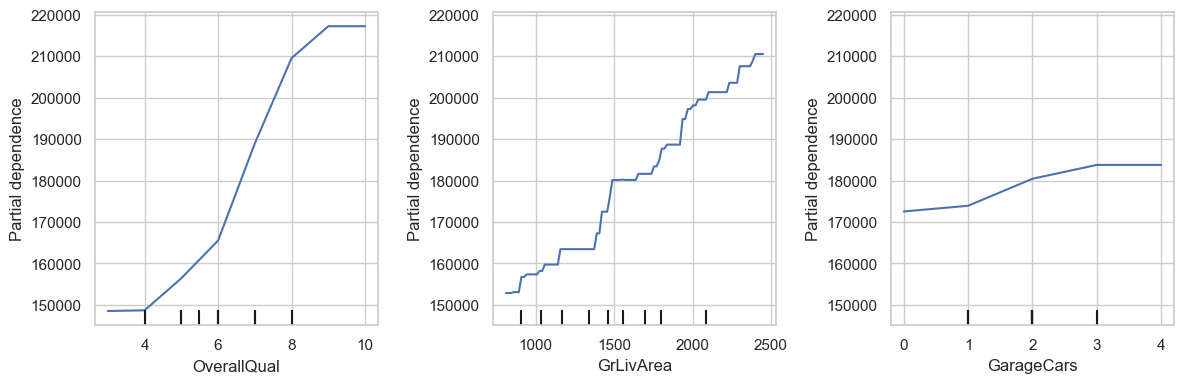

In [19]:

from sklearn.inspection import PartialDependenceDisplay

pdp_features = ["OverallQual", "GrLivArea", "GarageCars"]
fig, ax = plt.subplots(1, 3, figsize=(12,4))
PartialDependenceDisplay.from_estimator(best_pipe, X_sample, features=pdp_features, ax=ax)
plt.tight_layout()
pdp_fig = FIG_DIR / "pdp_top_features.png"
plt.savefig(pdp_fig, bbox_inches="tight")
pdp_fig


PosixPath('figures/group_mae.png')

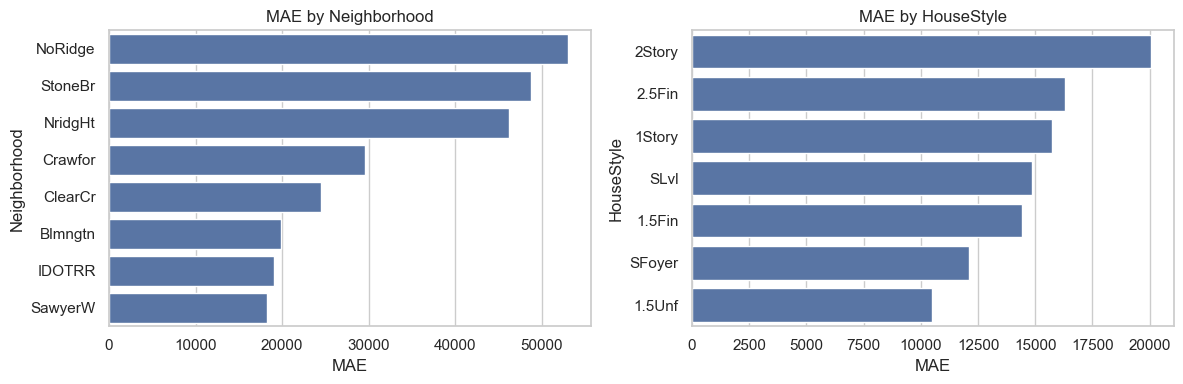

In [20]:

# Group MAE by Neighborhood (top 8) and HouseStyle (all)
groups = []
for col, topn in [("Neighborhood", 8), ("HouseStyle", None)]:
    d = (
        pd.DataFrame({col: X_test[col], "y": y_test, "pred": preds})
        .assign(abs_err=lambda t: (t["y"] - t["pred"]).abs())
        .groupby(col)
        .agg(count=("y", "size"), mae=("abs_err", "mean"))
        .sort_values("mae", ascending=False)
    )
    if topn:
        d = d.head(topn)
    groups.append((col, d))

fig, axes = plt.subplots(1, len(groups), figsize=(12,4))
for ax, (col, d) in zip(axes, groups):
    sns.barplot(x=d.mae, y=d.index, ax=ax)
    ax.set_title(f"MAE by {col}")
    ax.set_xlabel("MAE")
plt.tight_layout()
group_fig = FIG_DIR / "group_mae.png"
plt.savefig(group_fig, bbox_inches="tight")
group_fig



## Conclusion
- Log-target GradientBoosting remains best; broader tuning (12 draws) suggests slightly improved CV RMSE with n_estimators up to 500.
- Key drivers stay consistent across permutation, SHAP, and PDP: overall quality, living area, garage, basement.
- Residuals concentrate near zero but widen on high-price homes; group MAE highlights neighborhoods/house styles where errors spike.
- Deployment should package preprocessing + model, include monitoring on slice metrics, and revisit feature engineering for high-error groups.
